### Load and overview of data

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path_airlines = "./datasets/airlines.csv"
path_airport = "./datasets/airports.csv"
path_flights = "./datasets/flights.csv"

df_airlines = pd.read_csv(path_airlines, low_memory=False)
df_airport = pd.read_csv(path_airport, low_memory=False)
df_flights = pd.read_csv(path_flights, low_memory=False)

In [3]:
df_airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   IATA_CODE  14 non-null     object
 1   AIRLINE    14 non-null     object
dtypes: object(2)
memory usage: 352.0+ bytes


In [4]:
df_airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [5]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

We find that airport and airlne does not contain null values on critical columns

In [6]:
df_airport.isnull().sum()

IATA_CODE    0
AIRPORT      0
CITY         0
STATE        0
COUNTRY      0
LATITUDE     3
LONGITUDE    3
dtype: int64

In [7]:
df_airlines.isnull().sum()

IATA_CODE    0
AIRLINE      0
dtype: int64

We drop those columns with > 50 % missing values

In [8]:
df_flights.isnull().sum()/df_flights.shape[0]

YEAR                   0.000000
MONTH                  0.000000
DAY                    0.000000
DAY_OF_WEEK            0.000000
AIRLINE                0.000000
FLIGHT_NUMBER          0.000000
TAIL_NUMBER            0.002530
ORIGIN_AIRPORT         0.000000
DESTINATION_AIRPORT    0.000000
SCHEDULED_DEPARTURE    0.000000
DEPARTURE_TIME         0.014805
DEPARTURE_DELAY        0.014805
TAXI_OUT               0.015303
WHEELS_OFF             0.015303
SCHEDULED_TIME         0.000001
ELAPSED_TIME           0.018056
AIR_TIME               0.018056
DISTANCE               0.000000
WHEELS_ON              0.015898
TAXI_IN                0.015898
SCHEDULED_ARRIVAL      0.000000
ARRIVAL_TIME           0.015898
ARRIVAL_DELAY          0.018056
DIVERTED               0.000000
CANCELLED              0.000000
CANCELLATION_REASON    0.984554
AIR_SYSTEM_DELAY       0.817250
SECURITY_DELAY         0.817250
AIRLINE_DELAY          0.817250
LATE_AIRCRAFT_DELAY    0.817250
WEATHER_DELAY          0.817250
dtype: f

In [9]:
df_flights.drop(['CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'], axis=1, inplace=True)

For other columns, only less than 2% percents are null, we drop the NaN rows.

In [10]:
df_flights.dropna(inplace = True)

In [11]:
# transform df_airlines to dict
dict_airlines = df_airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()

# only keep flight starting and ending from airport in the airports.csv
df_flights = df_flights[(df_flights['ORIGIN_AIRPORT'].isin(df_airport['IATA_CODE'])) & (df_flights['DESTINATION_AIRPORT'].isin(df_airport['IATA_CODE']))]

df_flights.shape

(5231130, 25)

### Time distribution

In [12]:
print(df_flights['YEAR'].unique())
print(df_flights['MONTH'].unique())
print(df_flights['DAY'].unique())
print(df_flights['DAY_OF_WEEK'].unique())

[2015]
[ 1  2  3  4  5  6  7  8  9 11 12]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
[4 5 6 7 1 2 3]


The flights data are collected in 2015, we visualize the flight frequency gouuped according to each month and day of the week, we find that they are evenly distributed. 

<Axes: xlabel='YEAR,DAY_OF_WEEK'>

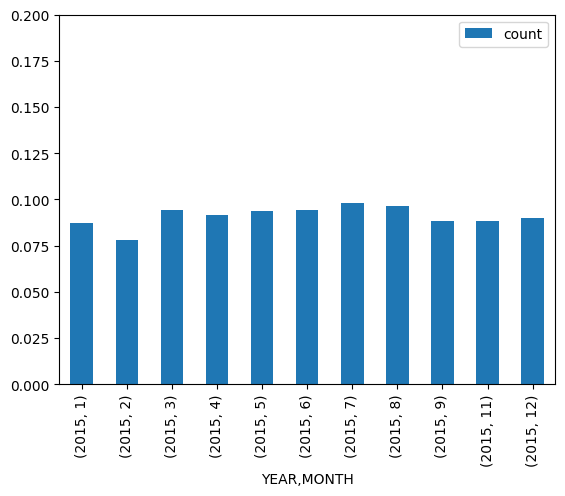

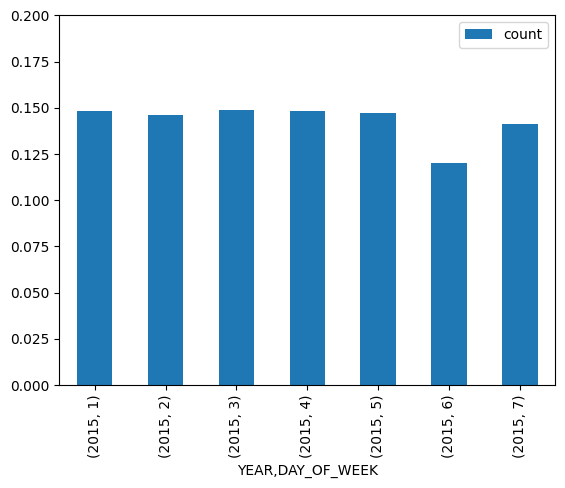

In [13]:
(df_flights.groupby([df_flights['YEAR'], df_flights['MONTH']]).agg({'count'})['FLIGHT_NUMBER']/df_flights['FLIGHT_NUMBER'].count()).plot(ylim=(0,0.2),kind="bar")
(df_flights.groupby([df_flights['YEAR'], df_flights['DAY_OF_WEEK']]).agg({'count'})['FLIGHT_NUMBER']/df_flights['FLIGHT_NUMBER'].count()).plot(ylim=(0,0.2),kind="bar")

Number of flights are fewer on 31st because some of the months do not have 31 days. For all other days, flights are evenly distributed.

<Axes: xlabel='YEAR,DAY'>

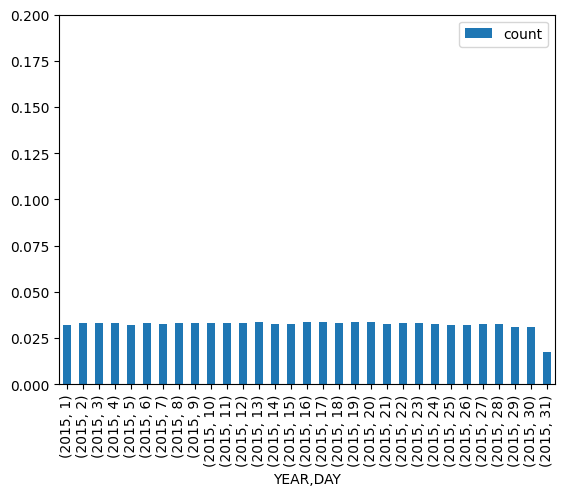

In [14]:
(df_flights.groupby([df_flights['YEAR'], df_flights['DAY']]).agg({'count'})['FLIGHT_NUMBER']/df_flights['FLIGHT_NUMBER'].count()).plot(ylim=(0,0.2),kind="bar")


### Airline Distribution

Southwest Airlines has made most number of flights.

<Axes: >

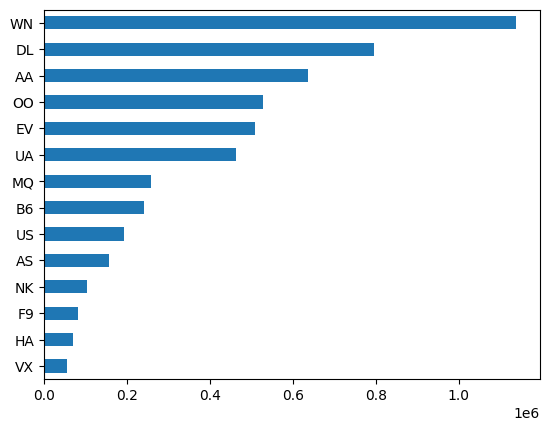

In [15]:
df_flights['AIRLINE'].value_counts().sort_values().plot(kind='barh')

<Axes: >

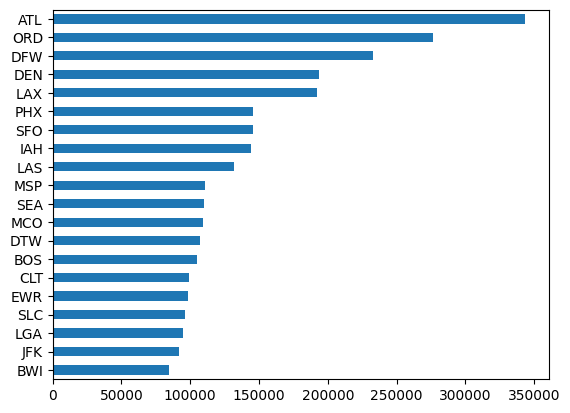

In [16]:
df_flights['ORIGIN_AIRPORT'].value_counts().sort_values().iloc[-20:].plot(kind='barh')

We plot the histogram for each airplane company. The x-axis is the ARRIVAL_DELAY in minutes, and the y-axis is the frequency. The fitting model is $a$-exp distribution. Smaller $a$ denotes the a large proportion of long delays. From the variance of $a$ in the estimation, we can conclude the exponential distribution model is plausible. 

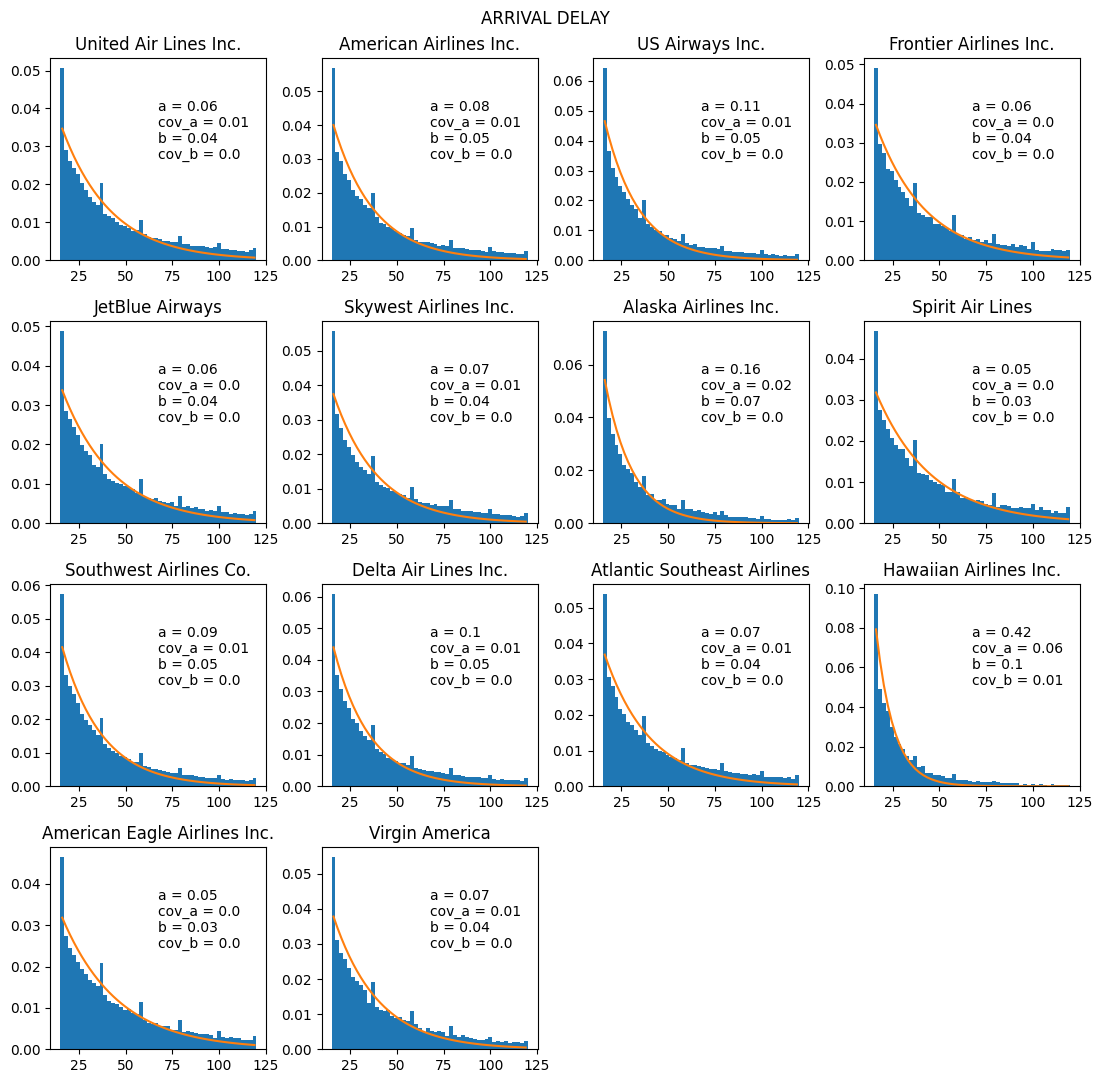

In [17]:
from scipy.optimize import curve_fit
dist_exp = lambda x, a, b: a*np.exp(-b*x)

fig = plt.figure(1, figsize=(11,11))
i = 0
for x in df_airlines['IATA_CODE']:
    i += 1
    ax = fig.add_subplot(4,4,i)
    counts, bins, patches = plt.hist(x = df_flights[df_flights['AIRLINE']==x]['ARRIVAL_DELAY'],range = (15,120), density=True, bins=50) # 15 min to 3 hours
    plt.title(dict_airlines[x], fontsize = 12)
    x_bin = 0.5 * (bins[1:] + bins[:-1])

    # fit the exp distribubtion
    popt, pcov = curve_fit(dist_exp, x_bin, counts, p0 = (1, 1e-6))
    perr = np.sqrt(np.diag(pcov))
    plt.plot(x_bin, dist_exp(x_bin, *popt))
    ax.text(0.5, 0.5, 'a = {}\ncov_a = {}\nb = {}\ncov_b = {}'.format(round(popt[0],2), round(perr[0],2), round(popt[1],2), round(perr[1],2)), transform=ax.transAxes)
plt.suptitle("ARRIVAL DELAY")
plt.tight_layout()


### Data Preprocessing

We change the format of "HHMM" string to minutes. 

In [18]:
def mintues(formatted_time):
    if formatted_time == 2400:
        formatted_time = 0
    formatted_time = "{0:04d}".format(int(formatted_time))
    return int(formatted_time[0:2])*60+int(formatted_time[2:4])

df_flights['SCHEDULED_DEPARTURE'] = df_flights['SCHEDULED_DEPARTURE'].apply(mintues)
df_flights['SCHEDULED_ARRIVAL'] = df_flights['SCHEDULED_ARRIVAL'].apply(mintues)


In the simple model, we only consider the following attributes. 

In [19]:
df_flights_data = df_flights[['MONTH', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'ARRIVAL_DELAY']]

To avoid extreme values, we discard those which delays over two hours.

In [20]:
df_flights_delays = df_flights_data.drop(df_flights_data[df_flights_data["ARRIVAL_DELAY"]>120].index)

We build the baseline model by linear regression based on the one-hot encoded 'MONTH', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', and the 'SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY', 'SCHEDULED_TIME' time in minutes. 

In [21]:
columns_to_remove = ['MONTH', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
df_flights_dummies = pd.get_dummies(df_flights_delays[columns_to_remove])
df_flights_delays.drop(columns_to_remove,axis=1,inplace=True)
df_flights_delays=pd.concat([df_flights_delays,df_flights_dummies],axis=1)

In [28]:
print(df_flights_delays.shape)

(5122314, 664)


In [23]:
df_flights_delays_sample = df_flights_delays.sample(1000000)

In [24]:
from sklearn import linear_model
X = df_flights_delays_sample.drop(["ARRIVAL_DELAY"],axis=1)
Y = df_flights_delays_sample['ARRIVAL_DELAY']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=0)
model = linear_model.LinearRegression().fit(X_train, y_train)

The MSE and error on the test set is

In [25]:

def baseline_test(model, X_test, Y_test):
    pred = model.predict(X_test)
    print("RMSD =", np.sqrt(sklearn.metrics.mean_squared_error(pred, Y_test)))
    count = 0
    for i, val in enumerate(Y_test):
        if abs(val-pred[i]) > 15:
            count += 1
    acc = count / len(pred)
    print('Error {:.2f}%'.format(acc * 100))
    return acc


acc = baseline_test(model, X_test, y_test)

RMSD = 11.996946147684856
Error 15.04%


We analyze the performance of the baseline by separating the airline in different cases. 

In [26]:
airline_names = list(x for x in df_flights_delays.columns if 'AIRLINE' in x)
errs = dict()
for airline_name in airline_names:
    X_test_1 = X_test[X_test[airline_name]==1]
    y_test_1 = y_test[X_test[airline_name]==1]
    acc = baseline_test(model, X_test_1, y_test_1)
    errs[airline_name] = acc


RMSD = 13.454206186866156
Error 19.57%
RMSD = 12.0492310274964
Error 17.08%
RMSD = 13.378212399528145
Error 18.74%
RMSD = 11.94124404760211
Error 15.06%
RMSD = 11.824876820727715
Error 13.77%
RMSD = 12.98482257587452
Error 18.09%
RMSD = 8.54606710824831
Error 7.07%
RMSD = 13.145135576149016
Error 16.30%
RMSD = 13.025075656049209
Error 16.42%
RMSD = 11.17450058734497
Error 12.58%
RMSD = 13.45014908070432
Error 20.05%
RMSD = 13.845286257713116
Error 19.86%
RMSD = 13.39670362335365
Error 18.57%
RMSD = 9.815256860372578
Error 10.00%


In [27]:
print(errs)

{'AIRLINE_AA': 0.19566538383633786, 'AIRLINE_AS': 0.1707558043800428, 'AIRLINE_B6': 0.18743812561874382, 'AIRLINE_DL': 0.15055645454245237, 'AIRLINE_EV': 0.1377013630731103, 'AIRLINE_F9': 0.18091779465170024, 'AIRLINE_HA': 0.07070340826686004, 'AIRLINE_MQ': 0.1629924474382527, 'AIRLINE_NK': 0.16420894776305925, 'AIRLINE_OO': 0.12576943910966662, 'AIRLINE_UA': 0.20052068594713907, 'AIRLINE_US': 0.19860388721598685, 'AIRLINE_VX': 0.18574938574938574, 'AIRLINE_WN': 0.10000229363058785}


We see that the linear model's performance on different airlines varies drastically.